In [5]:
import numpy as np
import os
import sys
import torch
import matplotlib.pyplot as plt
import time
from DeepQuantile import DQR
import numpy.random as rgt
from scipy.stats import norm, t
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from WAQR import WAQR, FullyConnectedNN
from joint import QuantES
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# 1.Parametric Model

This is an example of ES regression with $\tau=0.1$, following DGP1 of Chetverikov, Liu and Tsyvinski (2022)
where $Y=\varepsilon+X'\bar{\beta}$ with $\varepsilon\sim N(0,1)$. Will use half to train the quantile model, and feed half to train the second step.

In [ ]:
B = 10
l2_err = np.zeros((B,3))
out_l2_err = np.zeros((B,3))
runtime = np.zeros((B,3))
n = 2000 # number of training samples
m = 5000 # number of test samples
p = 5
tau = 0.1

betabar = np.array([0.3,0.5,0,0,0])
betabar1=np.array([0.5,0.3,0.5,0,0,0])
itc=0.5

In [ ]:
VaR = norm.ppf(tau)
SQ = norm.ppf(1-tau)
def tail_function(x) :
    return (x if x < VaR else 0)

def right_tail_function(x):
    return (x if x >SQ else 0)

CVaR = norm.expect(tail_function)/tau
CSQ = norm.expect(right_tail_function)/tau

In [ ]:
for b in range(B):
    X = np.random.standard_normal(size=(n, p))
    Xbar= np.hstack((np.ones((n, 1)), X))
    # Add a column of ones as the first column of the matrix
    #X = np.hstack((np.ones((n, 1)), X))
    err = rgt.normal(0,1,n)
    Y = err +X.dot(betabar)+itc
    X_test = np.random.standard_normal(size=(m, p))
    # Add a column of ones as the first column of the matrix
    X_test_bar = np.hstack((np.ones((m, 1)), X_test))
    true_test_ES=X_test.dot(betabar) + CVaR +itc
    true_test_SQ=X_test.dot(betabar) + CSQ +itc
    
    waqr1 = WAQR(X,Y,options={'depth' : 3})
    modells1 = waqr1.fit_ls(tau1=tau,intercept=True)
    betahat=modells1.coef_
    l2_err[b,0] = (np.mean((true_test_ES - modells1.predict(X_test))**2))**0.5
    
    init = QuantES(X, Y)
    ## two-step least squares
    m1 = init.twostep_fit(tau=tau, loss='L2',standardize=True)
    l2_err[b,1] = (np.mean((true_test_ES - X_test_bar.dot(m1['coef_e']))**2))**0.5
    
    m2 = init.joint_fit(tau=tau)
    l2_err[b,2] = (np.mean((true_test_ES - X_test_bar.dot(m2['coef_e']))**2))**0.5
    

In [ ]:
np.mean(l2_err, axis = 0)

In [ ]:
m1['coef_e']

In [ ]:
betahat

In [ ]:
modells1.intercept_

In [12]:
import math

In [19]:
np.random.seed(0)
X = np.random.rand(10000)
Y = 2 * np.sin(10*X) + 1 + 0.5 * np.random.randn(10000)

# Convert data to PyTorch tensors
train_x = torch.tensor(X, dtype=torch.float32).view(-1, 1)
train_y = torch.tensor(Y, dtype=torch.float32).view(-1, 1)

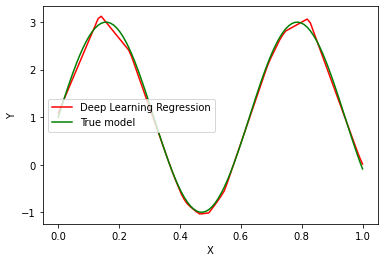

In [20]:
input_size = 1
output_size = 1
hidden_sizes = [64, 64]

model = FullyConnectedNN(input_size, output_size, hidden_sizes)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(train_x)
    loss = criterion(predictions, train_y)
    loss.backward()
    optimizer.step()

# Make predictions
model.eval()
test_x = torch.linspace(0, 1, 100).view(-1, 1)
test_y = model(test_x).detach().numpy()
true_y = (2*np.sin(10*test_x)+1).numpy()

# Plot the results
#plt.scatter(X, Y, label='Data')
plt.plot(test_x, test_y, label='Deep Learning Regression', color='r')
plt.plot(test_x, true_y, label='True model', color='g')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
